In [6]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# Montar Google Drive para acceder a los datos
from google.colab import drive
drive.mount('/content/drive')

# Ruta de los datos
images_dir = '/content/drive/MyDrive/1. CURSOS DE CICLOS/9/IA/images_selected'
annotations_dir = '/content/drive/MyDrive/1. CURSOS DE CICLOS/9/IA/xml_selected'

# Función para cargar datos y etiquetas
def load_data(images_dir, annotations_dir):
    images = []
    boxes = []
    labels = []

    for img_name in os.listdir(images_dir):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(images_dir, img_name)
            ann_path = os.path.join(annotations_dir, img_name.replace('.jpg', '.xml'))

            image = Image.open(img_path).resize((256, 256))
            image = np.array(image) / 255.0  # Normalizar la imagen
            images.append(image)

            tree = ET.parse(ann_path)
            root = tree.getroot()

            box = []
            label = []

            for obj in root.findall('object'):
                name = obj.find('name').text
                if name == 'blueberry':
                    label.append(0)  # Ripe blueberry
                else:
                    label.append(1)  # Unripe blueberry

                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text) / image.shape[1]
                ymin = int(bbox.find('ymin').text) / image.shape[0]
                xmax = int(bbox.find('xmax').text) / image.shape[1]
                ymax = int(bbox.find('ymax').text) / image.shape[0]
                box.append([xmin, ymin, xmax, ymax])

            boxes.append(box)
            labels.append(label)

    return np.array(images), boxes, labels

# Función para hacer padding a las cajas y etiquetas
def pad_boxes_and_labels(boxes, labels, max_objects):
    padded_boxes = []
    padded_labels = []

    for i in range(len(boxes)):
        padded_box = np.zeros((max_objects, 4))
        padded_label = np.zeros((max_objects,))

        padded_box[:len(boxes[i])] = boxes[i]
        padded_label[:len(labels[i])] = labels[i]

        padded_boxes.append(padded_box)
        padded_labels.append(padded_label)

    return np.array(padded_boxes), np.array(padded_labels)

# Cargar los datos
images, boxes, labels = load_data(images_dir, annotations_dir)

# Encontrar el número máximo de objetos en una imagen
max_objects = max(len(b) for b in boxes)

# Hacer padding a las cajas y etiquetas
padded_boxes, padded_labels = pad_boxes_and_labels(boxes, labels, max_objects)

# Dividir los datos en entrenamiento y prueba
train_images, test_images, train_boxes, test_boxes, train_labels, test_labels = train_test_split(
    images, padded_boxes, padded_labels, test_size=0.2, random_state=42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Definir el modelo
def create_model():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    bbox_output = tf.keras.layers.Dense(max_objects * 4)(x)
    class_output = tf.keras.layers.Dense(max_objects * 2, activation='softmax')(x)

    bbox_output = tf.keras.layers.Reshape((max_objects, 4), name='bbox_output')(bbox_output)
    class_output = tf.keras.layers.Reshape((max_objects, 2), name='class_output')(class_output)

    model = tf.keras.models.Model(inputs=inputs, outputs=[bbox_output, class_output])

    model.compile(optimizer='adam',
                  loss={'bbox_output': 'mse', 'class_output': 'sparse_categorical_crossentropy'},
                  metrics={'bbox_output': 'mse', 'class_output': 'accuracy'})

    return model

# Crear el modelo
model = create_model()


model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d_3[0][0]']            
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_4[0][0]']            
 g2D)                                                                                       

In [8]:
# Entrenar el modelo
history = model.fit(train_images, {'bbox_output': train_boxes, 'class_output': train_labels},
                    validation_data=(test_images, {'bbox_output': test_boxes, 'class_output': test_labels}),
                    epochs=20, batch_size=64)


Epoch 1/20
3/3 [==============================] - 50s 9s/step - loss: 11.1082 - bbox_output_loss: 10.4145 - class_output_loss: 0.6937 - bbox_output_mse: 10.4145 - class_output_accuracy: 0.6394 - val_loss: 10.9448 - val_bbox_output_loss: 10.2560 - val_class_output_loss: 0.6888 - val_bbox_output_mse: 10.2560 - val_class_output_accuracy: 0.9290
Epoch 2/20
3/3 [==============================] - 1s 323ms/step - loss: 11.0614 - bbox_output_loss: 10.3765 - class_output_loss: 0.6849 - bbox_output_mse: 10.3765 - class_output_accuracy: 0.9105 - val_loss: 10.7943 - val_bbox_output_loss: 10.1416 - val_class_output_loss: 0.6527 - val_bbox_output_mse: 10.1416 - val_class_output_accuracy: 0.9273
Epoch 3/20
3/3 [==============================] - 1s 325ms/step - loss: 10.5218 - bbox_output_loss: 9.9574 - class_output_loss: 0.5644 - bbox_output_mse: 9.9574 - class_output_accuracy: 0.9195 - val_loss: 7.3065 - val_bbox_output_loss: 7.0933 - val_class_output_loss: 0.2132 - val_bbox_output_mse: 7.0933 - val

In [9]:
# Evaluar el modelo
results = model.evaluate(test_images, {'bbox_output': test_boxes, 'class_output': test_labels})
print(f"Test Loss: {results[0]}, Test BBox Loss: {results[1]}, Test Class Loss: {results[2]}, Test Accuracy: {results[3]}")

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/1. CURSOS DE CICLOS/9/IA/blueberry_model.h5')


2/2 [==============================] - 2s 1s/step - loss: 5.5003 - bbox_output_loss: 5.3542 - class_output_loss: 0.1461 - bbox_output_mse: 5.3542 - class_output_accuracy: 0.9398
Test Loss: 5.500332832336426, Test BBox Loss: 5.354248046875, Test Class Loss: 0.14608481526374817, Test Accuracy: 5.354248523712158


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Hacer predicciones
predictions = model.predict(test_images)

# Obtener etiquetas predichas y reales
predicted_labels = np.argmax(predictions[1], axis=-1).flatten()
true_labels = test_labels.flatten()

# Crear matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Calcular y mostrar el reporte de clasificación
class_report = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(class_report)

# Calcular IoU (Intersection over Union)
def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calcular las coordenadas del rectángulo de intersección
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

ious = []
for i in range(len(test_boxes)):
    for j in range(max_objects):
        if np.sum(test_boxes[i][j]) > 0:  # Ignorar cajas vacías
            iou = calculate_iou(test_boxes[i][j], predictions[0][i][j])
            ious.append(iou)

mean_iou = np.mean(ious)
print(f'Mean IoU: {mean_iou}')


2/2 [==============================] - 0s 67ms/step
Confusion Matrix:
[[6052    0]
 [ 388    0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      6052
         1.0       0.00      0.00      0.00       388

    accuracy                           0.94      6440
   macro avg       0.47      0.50      0.48      6440
weighted avg       0.88      0.94      0.91      6440

Mean IoU: 0.007482956441609959


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step


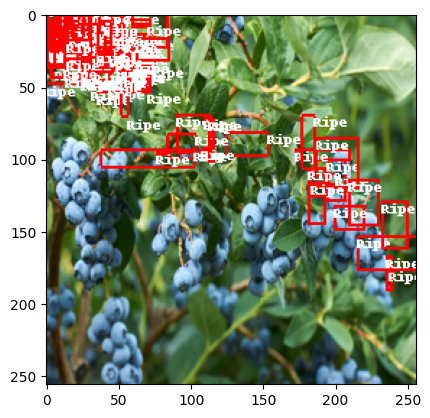

In [11]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Función para cargar y procesar una imagen
def load_and_process_image(image_path):
    image = Image.open(image_path).resize((256, 256))
    image = np.array(image) / 255.0  # Normalizar la imagen
    image = np.expand_dims(image, axis=0)  # Añadir dimensión de batch
    return image

# Función para mostrar la imagen con las cajas delimitadoras y las etiquetas
def show_image_with_boxes(image, boxes, labels):
    image = Image.fromarray((image[0] * 255).astype(np.uint8))
    draw = ImageDraw.Draw(image)
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin * 256, ymin * 256, xmax * 256, ymax * 256], outline='red' if label == 0 else 'blue', width=2)
        draw.text((xmin * 256, ymin * 256), 'Ripe' if label == 0 else 'Unripe', fill='white')
    plt.imshow(image)
    plt.show()

# Ruta de la imagen a probar
image_path = '/content/drive/MyDrive/1. CURSOS DE CICLOS/9/IA/imagenx.jpg'

# Cargar y procesar la imagen
test_image = load_and_process_image(image_path)

# Cargar el modelo
model = tf.keras.models.load_model('/content/drive/MyDrive/1. CURSOS DE CICLOS/9/IA/blueberry_model.h5')

# Hacer la predicción
bbox_preds, class_preds = model.predict(test_image)

# Convertir las predicciones en las etiquetas correspondientes
boxes = bbox_preds[0]
labels = np.argmax(class_preds[0], axis=-1)

# Mostrar la imagen con las cajas delimitadoras y las etiquetas
show_image_with_boxes(test_image, boxes, labels)


In [ ]:
#images_dir = '/content/drive/MyDrive/1. CURSOS DE CICLOS/9/IA/images_selected'
#annotations_dir = '/content/drive/MyDrive/1. CURSOS DE CICLOS/9/IA/xml_selected'
#model.save('/content/drive/MyDrive/1. CURSOS DE CICLOS/9/IA/blueberry_model.h5')